# Before getting started

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# colors
c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

In [ ]:
# get xGASS catalog
!wget -O xGASS_representative_sample.csv https://www.dropbox.com/s/hd81uq75gsm6i0z/xGASS_representative_sample.csv

# get and untar images
# !wget -O images-xGASS.tar.gz https://www.dropbox.com/s/0c3dp4dt3tlfjl8/images-xGASS.tar.gz
# !tar xzf images-xGASS.tar.gz 

# Can we predict a galaxy's neutral hydrogen (HI) content?

## Examine data with `pandas`

In [39]:
df = pd.read_csv('xGASS_representative_sample.csv', index_col='GASS')

np.random.seed(42)
df.sample(5)

,AGCnr,SDSS,PLATEID,MJD,FIBERID,RA,DEC,zSDSS,Dlum,lgMstar,expAB_r,model_r,merr_r,ext_r,petrR50_r,petrR90_r,petrR50_z,lgmust,CINDX,INCL,NUVr,lgSFR_tot_median,SFR_best,SFRerr_best,SFRcase_best,HIsrc,HI_FLAG,xGASSDR,zHI,W50cor,lgMHI,lgGF,HIconf_flag,weight,group_id_B,NYU_id,env_code_B,Ngal_B,yang_shred_code,logMh_Mst_B,lvir_ratB
GASS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108064,4399,J082607.43+212724.1,1927,53321,554,126.530991,21.456709,0.014968,64.8,9.562119,0.347443,14.6820,0.0027,0.1203,7.51,18.95,6.68,8.15,2.52,73.1,2.30,-0.445112,0.379401,0.109526,1,2,0,0,0.014940,228.0,9.480,-0.082,0.0,2.343,82,1873986,0,70,0,13.9322,0.037653
3504,112859,J011823.44+133728.4,423,51821,46,19.597670,13.624570,0.038010,167.5,10.159000,0.939227,15.4495,0.0042,0.1064,8.53,15.68,6.53,7.98,1.84,20.5,2.81,-0.350532,0.739195,0.107634,1,3,1,1,0.038016,48.0,9.647,-0.512,0.0,0.564,110777,379025,1,1,0,11.7834,-3.794999
112116,0,J125606.10+274041.1,2241,54169,236,194.025420,27.678110,0.016483,71.5,9.118738,0.614720,15.1316,0.0029,0.0244,3.23,7.81,3.32,8.23,2.42,53.6,1.69,-0.182117,1.253867,0.136318,1,3,1,4,0.016325,110.0,8.437,-0.682,0.0,2.294,412092,2227797,1,1,0,0.0000,-99.000000
111013,6977,J115905.47+245920.2,2655,54184,435,179.772800,24.988960,0.013479,58.3,9.919288,0.791741,13.8649,0.0020,0.0600,8.47,19.85,7.18,8.53,2.34,38.6,2.71,-0.559622,0.391057,0.115832,1,1,0,0,0.013499,196.0,9.250,-0.669,0.0,1.308,445,2322871,0,27,0,12.9880,-0.439150
52045,180412,J083836.42+173809.2,2276,53712,610,129.651800,17.635900,0.041480,183.3,10.174000,0.961924,15.5552,0.0031,0.0833,3.97,9.44,3.45,8.47,2.38,16.2,2.08,0.122838,1.956346,0.331093,1,3,1,3,0.041499,109.0,9.771,-0.403,0.0,0.564,404722,2201247,1,1,0,11.7755,-3.204295


## A very simplified glossary for xGASS
For more details, see the xGASS paper by [Catinella et al. (2018)](https://core.ac.uk/download/pdf/154748757.pdf).

### Observational quantities
- `zSDSS` - Optical redshift from SDSS spectroscopy
- `Dlum` - Luminosity distance in Mpc
- `model_r` - $r$-band model magnitude corrected for Galactic extinction (`ext_r`)
- `NUVr` - $NUV - r$ color corrected for extinction in magnitudes

### Derived shape quantities
- `expAB_r` - Axial ratio from exponential disk fit to $r$-band light
- `petrR50_r` - Radius containing 50% of the Petrosian $r$-band flux
- `lgmust` - Log stellar mass surface density in units of $M_\odot\ {\rm kpc}^{-2}$
- `CINDX` - Concentration index
- `INCL` - Galaxy inclination

### Derived physical properties
- `lgMstar` - Log stellar mass in units of $M_\odot$, based on MPA-JHU value-added SDSS catalogs
- `SFR_best` - Star formation rate in $M_\odot\ {\rm yr}^{-1}$
- `lgGF` - **Log gas/stellar mass fraction** i.e., what we want to predict

## Examine and clean features

Let's pick a few columns and see if we can combine them in order to predict the logarithmic HI gas-to-stellar mass fraction. Note that I *won't* use `lgMstar` or `lgmust` as features, since the stellar mass is a part of what we're trying to estimate! 

In [40]:
observational_features = ['model_r', 'NUVr']
morphological_features = ['expAB_r', 'petrR50_r', 'CINDX', 'INCL']

features = observational_features + morphological_features

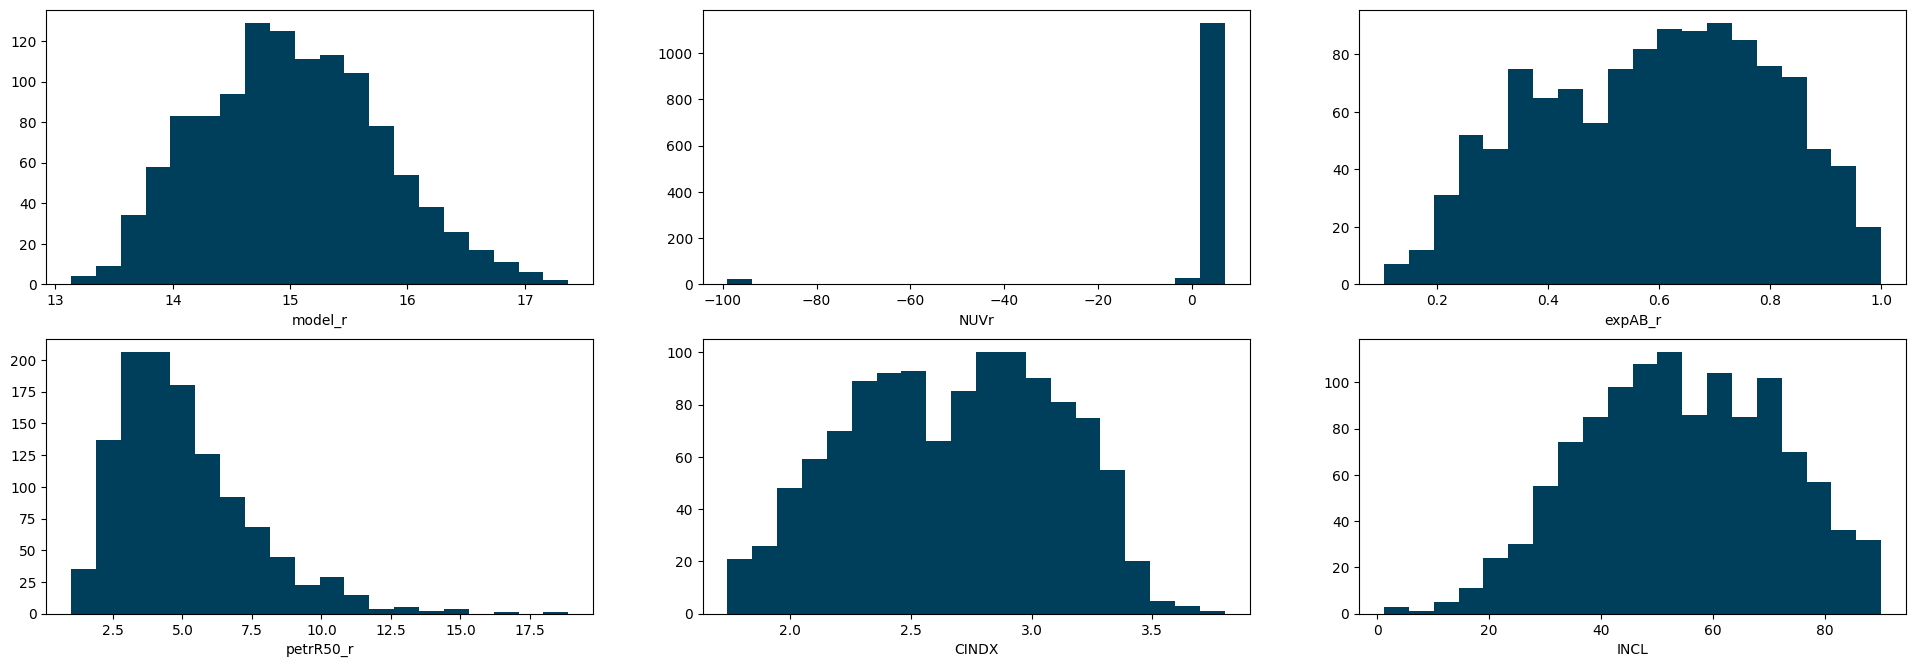

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(24, 8), dpi=100)

for feature, ax in zip(features, axes.flat):
    df[feature].plot.hist(bins=20, color=c0, ax=ax)
    ax.set(xlabel=feature, ylabel='')

fig.subplots_adjust()

A small amount of data cleaning: galaxies without $NUV-r$ colors?

In [42]:
sum(df.NUVr < -90), len(df)

(22, 1179)

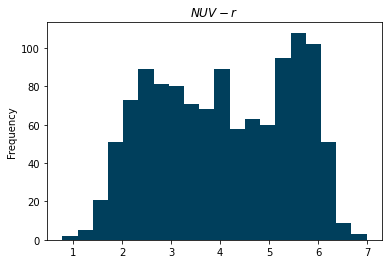

In [43]:
# impute missing values for 22 galaxies
df.NUVr = np.where(df.NUVr < -90, df.NUVr.median(), df.NUVr)
df.NUVr.plot.hist(bins=20, color=c0, title='$NUV - r$')

Let's also look at the depedent variable

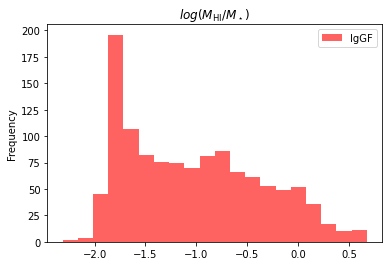

In [44]:
target = ['lgGF']

df[target].plot.hist(bins=20, color=c3, title=r'$log(M_{\rm HI}/M_\star)$')

## Bonus: visualizing correlations

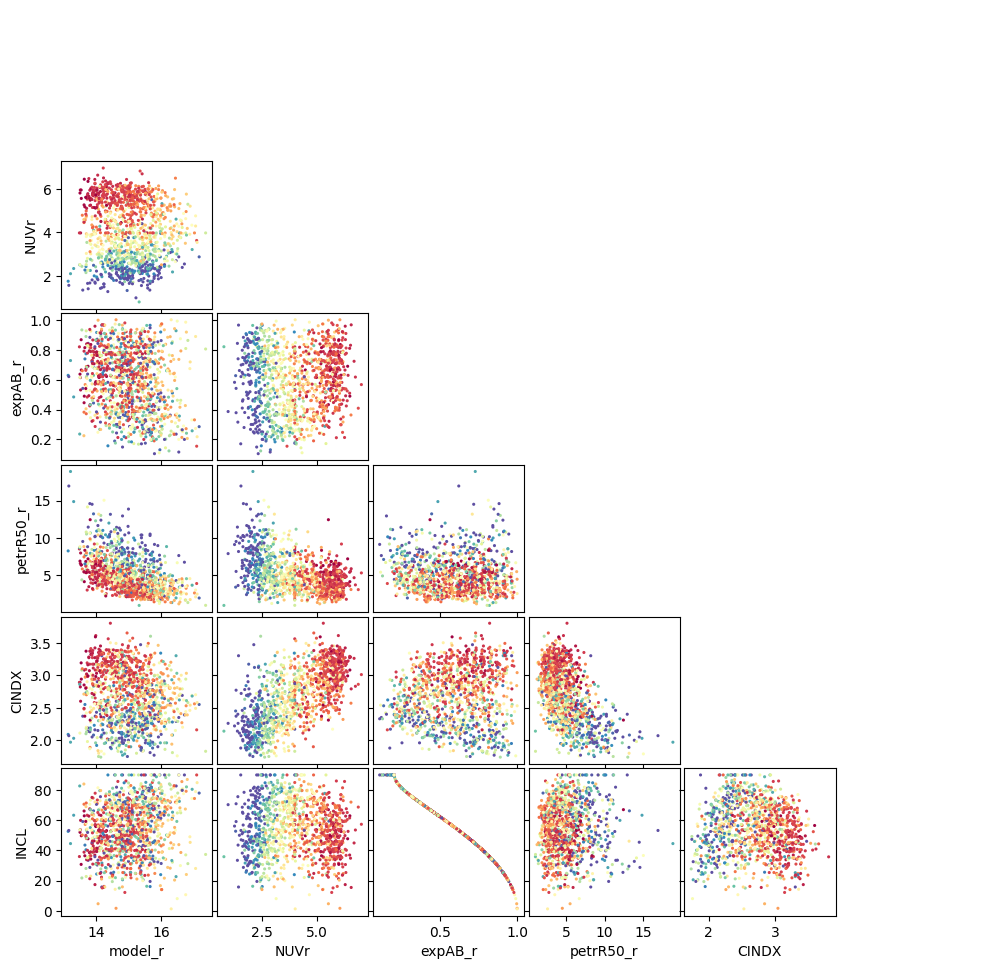

In [45]:
# plotting features, and letting the *color* represent the target (gas fraction)

fig, axes = plt.subplots(len(features), len(features), figsize=(12, 12), dpi=100)


for i, col_y in enumerate(features):
    for j, col_x in enumerate(features):
        ax = axes[i ,j]

        if i <= j: 
            ax.axis('off')
        else: 
            ax.scatter(df[col_x], df[col_y], c=df[target].values, s=5, edgecolor='none', vmin=-2, vmax=0, cmap='Spectral')
        
        if i == len(features) - 1: 
            ax.set_xlabel(col_x)
        else:
            ax.set_xticklabels([])
        if j == 0: 
            ax.set_ylabel(col_y)
        else:
            ax.set_yticklabels([])


fig.subplots_adjust(wspace=0.03, hspace=0.03)

Looks like the inclination is simply the arctangent of the axial ratio. Also, $NUV-r$ color is strongly correlated with HI gas mass fraction (which is well-known, see e.g., Kannappan 2004).

# Polynomial regression

## Multivariate Linear regression

So we have some features $X$, some targets $y$, and we want to make predictions $\hat y$ that are close to the true values ($y$). The easiest way to formulate this prediction problem is via a linear combination of features:
$$ \hat y = \vec A \cdot \vec x = A_1x_1 + A_2x_2 + \cdots + A_m x_m,$$

where $\vec x = (\rm model\_r, NUVr, expAB\_r, petrR50\_r, CINDX, INCL)$ are the **features**, $\vec A$ contains our model parameters (linear coefficients), and $y$ is our **target**, $\rm lgGF$. Here we have written it for a single galaxy example, but we can also generalize things to a whole sample of galaxies:
$$ \hat{y} = \mathbf{X} \vec{A}.$$

Due to linear algebra and blah blah this is uniquely solvable if something or other, whatever. Read the [Hogg et al. (2010) tutorial](https://arxiv.org/abs/1008.4686) if you're interested in all that, but I won't cover it here.

Assuming a data set with `n_samples` galaxies, and `n_features` = 6 features, then we should find that the shapes of these arrays in Python are:
```
y.shape is (n_samples, 1)
X.shape is (n_samples, n_features)
A.shape is (1, n_features)
```

Let's now write this model in code with `scikit-learn`!

In [46]:
y = df[target].values
X = df[features].values
print(f'y.shape is {y.shape}') 
print(f'X.shape is {X.shape}') 

y.shape is (1179, 1)
X.shape is (1179, 6)


In [47]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [48]:
A = model.coef_

print(f'A.shape is {A.shape}')

A.shape is (1, 6)


Hooray! Now we can look at the correlation coefficient $R^2$ to see how well we've recovered this relationship.

In [49]:
R2 = model.score(X, y)
R2

0.771107731418904

In [50]:
A.shape, X.shape

((1, 6), (1179, 6))

In [51]:
# root mean squared error
def rmse(y, y_hat):
    return np.sqrt(((y - y_hat)**2).mean())

In [52]:
rmse(y, model.predict(X))

0.31812115413287306

## Train-test split

Not bad... but hang on. We're training and testing on the *same* data. Is this relationship generalizeable?

In order to find out, we will need to split our data into training and validation (and/or testing) subsets. Note that the word validation and test set can sometimes mean the same thing, depending on context! (This is just one of many frustrating things with machine learning jargon.)

I will use the following definitions:
- **Training**: The data used to update *model parameters* (e.g., coefficients or matrix element values).
- **Validation**: The data used to update *model selection* (for instance, we might change *hyperparameters* of a model based on the validation metrics).
- **Testing**: The data used to evaluate the final model score.

Not everybody uses these definitions! And sometimes you might see that there is no validation set because hyperparameters don't need to be adjusted. (What are hyperparameters anyway? We'll see later.)

I might also abbreviate these as train, valid, and test.

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(943, 6) (236, 6)


In this case, we've randomly reserved 20% of the data for testing, and kept 80% of the data for training the model. After training the model (i.e., determining the values for $\vec A$), we will check the $R^2$ score between the *model predictions* $\hat y_{\rm test} = \mathbf{X}_{\rm test} \vec A$ and the true *targets*, $y_{\rm test}$.

In [54]:
# re-initialize model
model = LinearRegression()

# fit model coefficients to training data
model.fit(X_train, y_train)

# evaluate on test data
R2 = model.score(X_test, y_test)
R2

0.6987645898827902

Again we got something like $R^2 = 0.79$. To be sure that our result is robust, we can perform **cross-validation** (jargon alert!).

Here is a visual example of $k$-fold cross-validation, where $k$ = 5. 
![](https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png)

Basically we take permutations of the test-train 80%-20% split until we are able to test on the entire data set, without directly training on any of the test subsets. This means that we need to reset our model between each iteration (or "fold").


In [55]:
from sklearn.model_selection import KFold, cross_validate

cv = cross_validate(
    estimator=LinearRegression(), 
    X=X, 
    y=y, 
    cv=5          # number of folds
)

print(f'Cross-validated score: {cv["test_score"].mean():.3f} +/- {cv["test_score"].std():.3f}')

Cross-validated score: 0.752 +/- 0.060


In [56]:
# Implement this ourselves and also report the root mean squared error (RMSE)

kf = KFold(5)

cv_scores = []
cv_rmse = []    

for train_index, test_index in kf.split(X):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    cv_scores.append(model.score(X_test, y_test))
    cv_rmse.append(rmse(y_test, model.predict(X_test)))

print(f'Cross-validated score: {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}')
print(f'Cross-validated RMSE:  {np.mean(cv_rmse):.3f} +/- {np.std(cv_rmse):.3f}')


Cross-validated score: 0.752 +/- 0.060
Cross-validated RMSE:  0.320 +/- 0.012


## Quadratic and higher-order polynomial models

So far we've been using the features in a linear model. What if we wanted a more complicated model?

Fortunately, we can modify the *features* to be polynomial versions of the original ones while keeping the model linear (since the model is just a bunch of coefficients).

A quadratic model would have corresponding coefficients to these new features:
$$ X = (x_1^2, x_1x_2, \cdots x_1x_m, x_2^2, x_2x_3, \cdots, x_m^2).$$


In [57]:
from sklearn.preprocessing import PolynomialFeatures

lin = PolynomialFeatures(degree=1)
X_lin = lin.fit_transform(X)

quad = PolynomialFeatures(degree=2)

X_quad = quad.fit_transform(X)

print(X.shape, X_lin.shape, X_quad.shape)

(1179, 6) (1179, 7) (1179, 28)


Why does `X_lin` have an extra feature compared to `X`? This is because we are include a constant (the y-intercept, also known as the *bias*) in there. `X_quad` then has $7 \times 8 / 2 = 28$ terms, including combinations of all bias terms multiplied with the original features. And if we wanted a cubic model, we would find that `X_cubic` has $7 \times 8 \times 9 / (3!) = 84$ terms.

Given this exponential rise in number of parameters with the polynomial degree, we do not want to go too crazy with high-order polynomial models. They will become computationally expensive, and also will be in danger of **overfitting** (more on that below).

In [58]:
def k_fold_evaluate_polynomial(X, y, polynomial_degree=1, k=5):
    """Perform a k-fold cross-validation using a polynomial model.
    Prints R^2 and RMSE results. 
    """

    X_poly = PolynomialFeatures(degree=polynomial_degree).fit_transform(X)
    print(f'Evaluating model with polynomial degree {polynomial_degree}.')

    # same cross-val loop as above
    kf = KFold(5)

    cv_scores = []
    cv_rmse = []    

    for train_index, test_index in kf.split(X_poly):
        X_train = X_poly[train_index]
        y_train = y[train_index]
        X_test = X_poly[test_index]
        y_test = y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        cv_scores.append(model.score(X_test, y_test))
        cv_rmse.append(rmse(y_test, model.predict(X_test)))

    print(f'    R^2:   {np.mean(cv_scores):.3f} +/- {np.std(cv_scores):.3f}')
    print(f'    RMSE:  {np.mean(cv_rmse):.3f} +/- {np.std(cv_rmse):.3f}\n')

In [59]:
k_fold_evaluate_polynomial(X, y, polynomial_degree=2)
k_fold_evaluate_polynomial(X, y, polynomial_degree=3)
k_fold_evaluate_polynomial(X, y, polynomial_degree=4)


Evaluating model with polynomial degree 2.
    R^2:   0.792 +/- 0.051
    RMSE:  0.293 +/- 0.011

Evaluating model with polynomial degree 3.
    R^2:   0.778 +/- 0.049
    RMSE:  0.304 +/- 0.011

Evaluating model with polynomial degree 4.
    R^2:   -0.645 +/- 2.104
    RMSE:  0.712 +/- 0.462



## Overfitting

So, what does it mean to "overfit" a model? Well, a picture is worth a thousand words:

![](https://qph.fs.quoracdn.net/main-qimg-b4112b5d856f4f0da349460aeed854d8)

Although there is only a single feature here (or indepedent variable, $x$), we can intuitively understand why linear models might perform worse than low-order polynomials, and why low-order polynomials might outperform high-order polynomials!

Even in the example above, we saw that a cubic model isn't any better than a quadratic model. And if we try higher-order combinations of features, we'd get ridiculously bad results:


In [60]:
# 6th-order model -- BAD IDEA!
k_fold_evaluate_polynomial(X, y, polynomial_degree=6)


Evaluating model with polynomial degree 6.
    R^2:   -1670.569 +/- 1227.989
    RMSE:  24.601 +/- 10.523



With a bit of work, we can visualize these models. For simplicity, though, we will only consider a model with two features (and polynomial combinations of them plus the bias term):
$$ X = (x_1, x_2, 1) = (\rm NUVr, petrR50\_r, 1),$$

so concretely, we could have polynomial models like:
$$ \hat y_{\rm linear} = A_1 x_1 + A_2 x_2 + A_3,$$
$$ \hat y_{\rm quadratic} = A_1 x_1^2 + A_2 x_1 x_2 + A_3 x_2^2 + A_4x_1 + A_5 x_2 + A_6,$$
etc.

In [61]:
X.shape

(1179, 6)

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_polynomial_model(deg):
    """Plot NUV-r color vs Petrosian half-light radius as features for 
    estimating the log gas mass fraction. Show model based on training 
    data, and scatterplot points from the test data.
    """

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
    ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

    # create a grid of points to plot model results
    NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
    petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
    xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

    # polynomial model on *training data*
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_poly = PolynomialFeatures(deg).fit_transform(X_train[:, (1, 3)])
    model = LinearRegression()
    model.fit(X_poly, y_train)

    # plot results from model
    X_grid = PolynomialFeatures(deg).fit_transform(np.c_[xx1.ravel(), xx2.ravel()])
    p = model.predict(X_grid).reshape(xx1.shape)
    ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=.2)

    # compare with test set
    sc = ax.scatter(X_test[:, 1], X_test[:, 3], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

    # colorbar + other axis details
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
    cbar.set_label('log gas mass fraction')

    ax.set_xlabel('$NUV-r$')
    ax.set_ylabel('$r$-band Petrosian half-light radius')

    ax.text(3, 17, f'Polynomial degree {deg}', fontsize=16)
    plt.show()

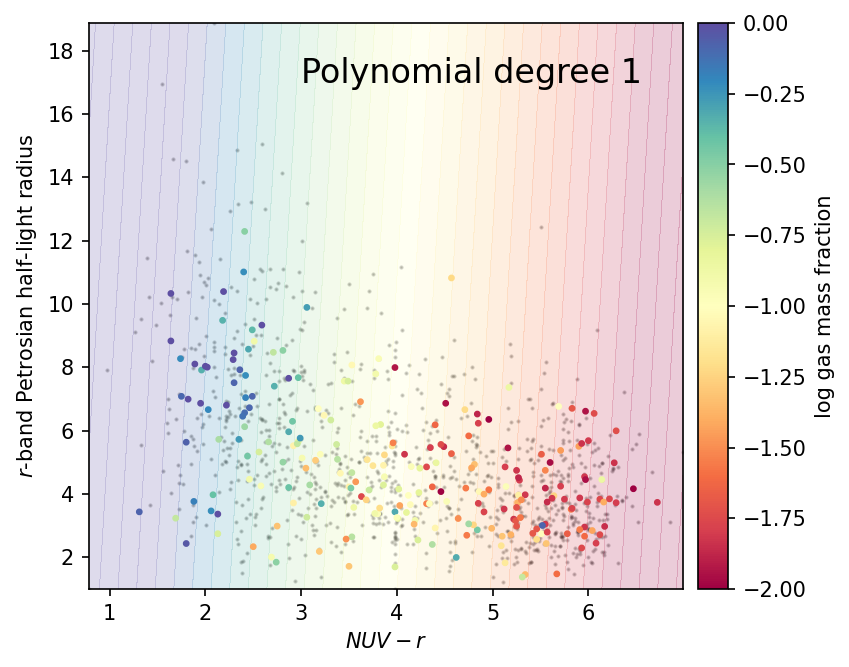

In [63]:
plot_polynomial_model(1)

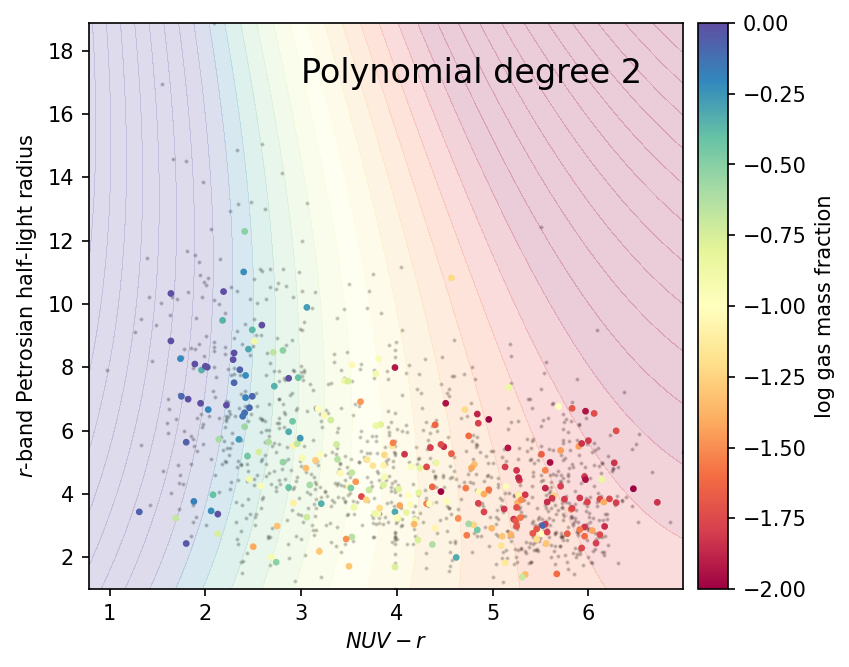

In [64]:
plot_polynomial_model(2)

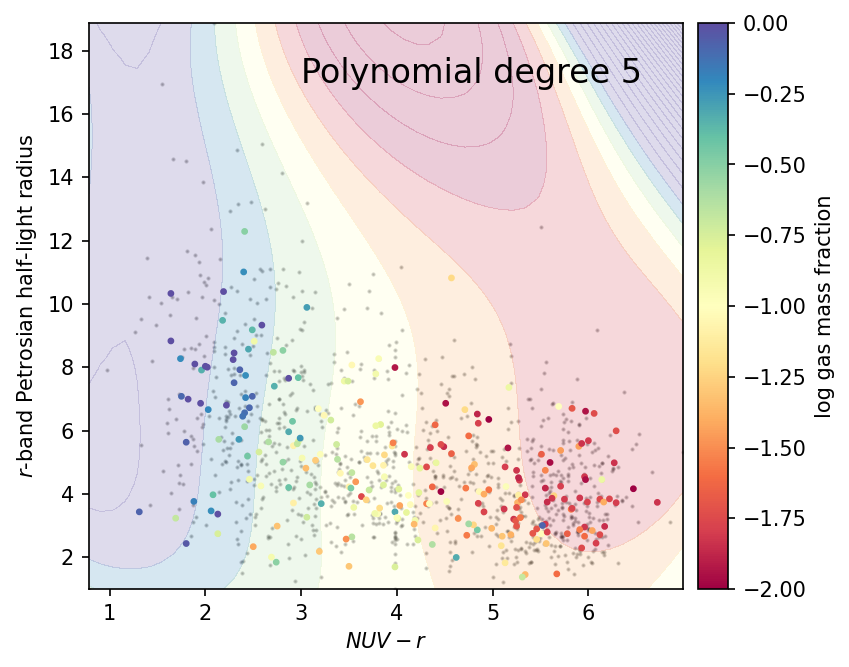

In [65]:
plot_polynomial_model(5)

# Decision trees

Another way to solve classification or regression problems is by using a ton of `if-else` statements. If you have a whole bunch of nested `if-else` statements, you have basically constructed a **decision tree**. See the image below for an example of a decision tree used in regression ([credit to this blog post](https://mljar.com/blog/visualize-decision-tree/)).

![](https://mljar.com/blog/visualize-decision-tree/output_32_0.svg)

In [66]:
from sklearn.tree import DecisionTreeRegressor

# note that there are lots of "hyperparameters" for this model
# DecisionTreeRegressor?

In our examples above, the polynomial degree is an example of a **hyperparameter** - hyperparameters govern the structure of the model. 

For decision trees, we can see that there are lots of choices of hyperparameters: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, etc. These can alter the behavior of a decision tree greatly! Often times people will run decision trees (and other variants) with the default the hyperparameters; these can lead to extremely poor results and you should immediately be suspicious if there was no attempt made to optimize hyperparameters!

In [81]:
# only use the two features from above
X_train, X_test, y_train, y_test = train_test_split(X[:, [1, 3]], y, test_size=0.2, random_state=42)

In [82]:
# no hyperparameter tuning
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)
print(dtree.score(X_test,  y_test))

0.41756860771502824


In [83]:
preds = dtree.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.9253


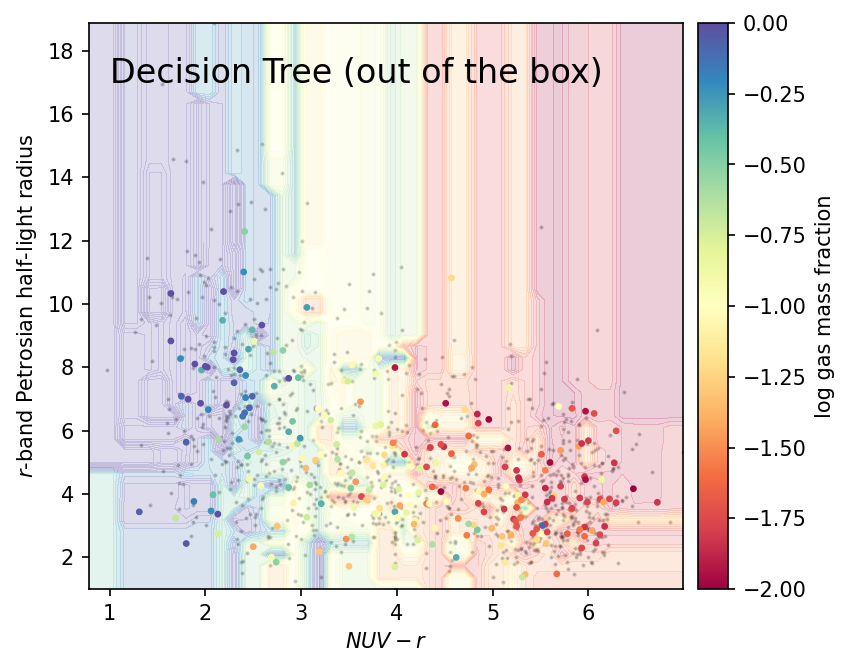

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

# create a grid of points to plot model results
NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

# plot results from decision tree
X_grid = np.c_[xx1.ravel(), xx2.ravel()]
p = dtree.predict(X_grid).reshape(xx1.shape)
ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=0.2, )

# compare with test set
sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

# colorbar + other axis details
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label('log gas mass fraction')

ax.set_xlabel('$NUV-r$')
ax.set_ylabel('$r$-band Petrosian half-light radius')

ax.text(1, 17, f'Decision Tree (out of the box)', fontsize=16);

## Random forests

Random forests take subsamples of the data and train many decision trees. Each decision tree model is not as good as if it had been trained using the entire data set, but the *ensemble* of these (uncorrelated) models can be much more powerful, and crucially, is more likely to be robust to outliers.

In [101]:
from sklearn.ensemble import RandomForestRegressor

# again no hyperparameter
rf = RandomForestRegressor()
rf.fit(X_train, y_train.flatten())
rf.score(X_test, y_test.flatten())

0.6043188796087964

In [102]:
preds = rf.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.8617


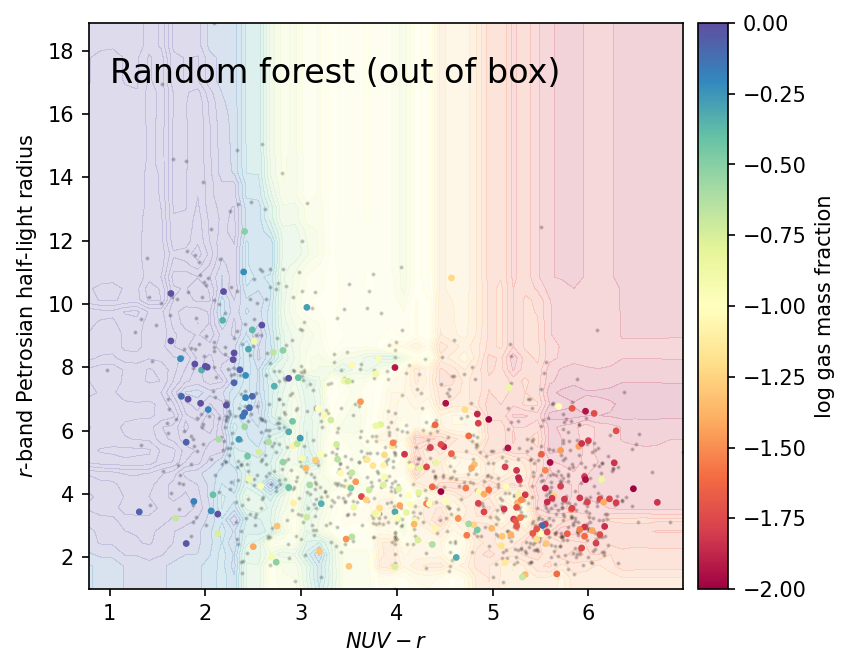

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

# create a grid of points to plot model results
NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

# plot results from model
X_grid = np.c_[xx1.ravel(), xx2.ravel()]
p = rf.predict(X_grid).reshape(xx1.shape)
ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=.2)

# compare with test set
sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

# colorbar + other axis details
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label('log gas mass fraction')

ax.set_xlabel('$NUV-r$')
ax.set_ylabel('$r$-band Petrosian half-light radius')

ax.text(1, 17, f'Random forest (out of box)', fontsize=16);

## Optimizing hyperparameters

There is a lot to be said about how to optimize model hyperparameters, and some of it can be found in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/grid_search.html). People often use a **grid search**, which involves choosing combinations of hyperparameters from some (prior, uninformative, ...) distribution. However, a **random search** can often be more efficient ([see example here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py))!

In [86]:
import scipy.stats as stats

# random forest hyperparameter distributions
hyperparameter_distributions = {
    'n_estimators': np.arange(50, 300, 1).astype(int),
    'max_features': np.arange(0.1, 1, 0.05),
}

In [87]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=hyperparameter_distributions,
    n_iter=100
)

random_search.fit(X_train, y_train.flatten())

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

In [88]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                f"Mean validation score: {results['mean_test_score'][candidate]:.3f}" 
                f"(std: {results['std_test_score'][candidate]:.3f})"
            )
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.749(std: 0.028)
Parameters: {'n_estimators': 146, 'max_features': 0.1}

Model with rank: 2
Mean validation score: 0.749(std: 0.029)
Parameters: {'n_estimators': 292, 'max_features': 0.40000000000000013}

Model with rank: 3
Mean validation score: 0.748(std: 0.027)
Parameters: {'n_estimators': 256, 'max_features': 0.20000000000000004}



Examine results

In [97]:
preds = random_search.predict(X_test)
print(f'RMSE = {rmse(y_test, preds):.4f}')

RMSE = 0.8576


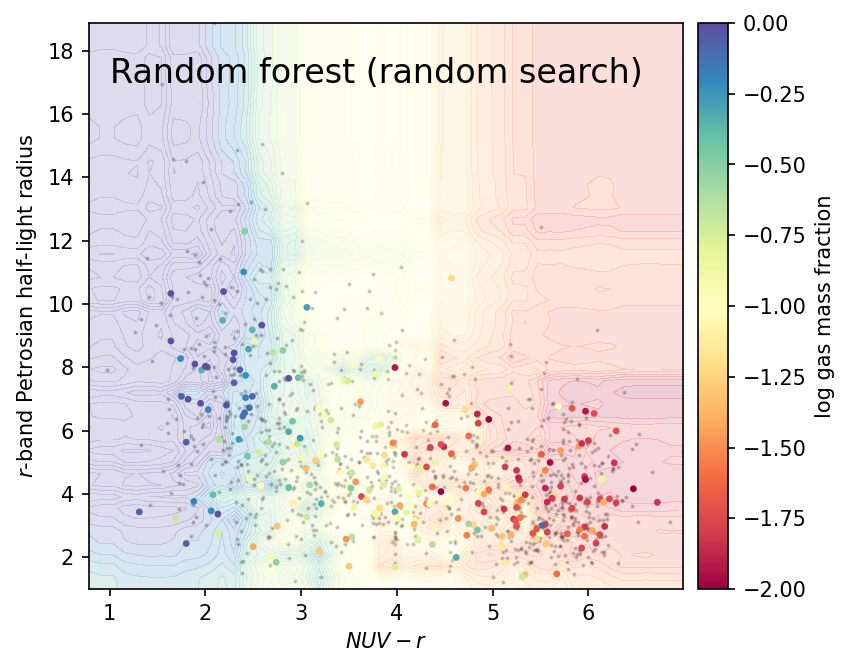

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 5), dpi=150)
ax.scatter(df['NUVr'], df['petrR50_r'], s=1, c='k', alpha=0.2)

# create a grid of points to plot model results
NUVr_min, NUVr_max = X[:, 1].min(), X[:, 1].max()
petroR_min, petroR_max = X[:, 3].min(), X[:, 3].max()
xx1, xx2 = np.meshgrid(np.linspace(NUVr_min, NUVr_max, 50), np.linspace(petroR_min, petroR_max, 50))

# plot results from model
X_grid = np.c_[xx1.ravel(), xx2.ravel()]
p = random_search.predict(X_grid).reshape(xx1.shape)
ax.contourf(xx1, xx2, p, vmin=-2, vmax=0, levels=40, cmap='Spectral', alpha=.2)

# compare with test set
sc = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=5, vmin=-2, vmax=0, cmap='Spectral')

# colorbar + other axis details
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = fig.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label('log gas mass fraction')

ax.set_xlabel('$NUV-r$')
ax.set_ylabel('$r$-band Petrosian half-light radius')

ax.text(1, 17, f'Random forest (random search)', fontsize=16);